<a href="https://colab.research.google.com/github/MichelleAppel/distribution-aware-image-to-image-translation/blob/master/toy_examples/Fly_AE_fakelatent.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### imports



In [5]:
import os.path
from PIL import Image

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
from torch.utils.data import Dataset, DataLoader
from torchvision.utils import make_grid
import torchvision.transforms as transforms

from itertools import chain

import numpy as np
import math
import itertools
import random

from scipy import signal

import matplotlib.pyplot as plt

import zipfile

import os
import pickle

from sklearn.manifold import TSNE
from sklearn.decomposition import PCA

import numpy as np
import os
import copy
from PIL import Image, ImageDraw, ImageFont

!pip install webcolors
from webcolors import hex_to_rgb

# Fly data experiment

## The Fly dataset

In [6]:
zipdataroot_A = '/content/drive/MyDrive/fly_data_ubc_2021/generated_fly_with_annotation.zip'
zipdataroot_B = '/content/drive/MyDrive/fly_data_ubc_2021/real_fly.zip'

dataroot_A = '/content/flydata/data_A'
dataroot_B = '/content/flydata/data_B'

if not os.path.exists(dataroot_A):
  with zipfile.ZipFile(zipdataroot_A, 'r') as zip_ref:
      zip_ref.extractall(dataroot_A)

if not os.path.exists(dataroot_B):
  with zipfile.ZipFile(zipdataroot_B, 'r') as zip_ref:
      zip_ref.extractall(dataroot_B)

In [7]:
IMG_EXTENSIONS = [
    '.jpg', '.JPG', '.jpeg', '.JPEG',
    '.png', '.PNG', '.ppm', '.PPM', '.bmp', '.BMP',
]

def is_image_file(filename):
    return any(filename.endswith(extension) for extension in IMG_EXTENSIONS)

def make_dataset(dir):
    images = []
    assert os.path.isdir(dir), '%s is not a valid directory' % dir

    for root, _, fnames in sorted(os.walk(dir)):
        for fname in fnames:
            if is_image_file(fname) and not fname.endswith('real_A.png') and not fname.endswith('render_pose.png'):
                path = os.path.join(root, fname)
                images.append(path)

    return images

In [8]:
def __adjust(img):
    ow, oh = img.size

    # the size needs to be a multiple of this number,
    # because going through generator network may change img size
    # and eventually cause size mismatch error
    mult = 4
    if ow % mult == 0 and oh % mult == 0:
        return img
    w = (ow - 1) // mult
    w = (w + 1) * mult
    h = (oh - 1) // mult
    h = (h + 1) * mult

    return img.resize((w, h), Image.BICUBIC)

def normalize(img):
  return img * 2 - 1


def get_transform():
    loadSize = 128
    osize = [loadSize, loadSize]

    transform_list = []
    transform_list.append(transforms.Lambda(
            lambda img: __adjust(img)))
    
    transform_list.append(transforms.Resize(osize, Image.BICUBIC))  
    transform_list += [transforms.ToTensor()]
                      #  transforms.Normalize((0.5, 0.5, 0.5),
                      #                       (0.5, 0.5, 0.5))]
    transform_list.append(transforms.Lambda(
            lambda img: normalize(img)))
    
    return transforms.Compose(transform_list)

In [9]:
class FlyDataset(Dataset):
  def __init__(self, annotations=False):
    self.dataroot_A = '/content/flydata/data_A'

    self.annotations = annotations
    if self.annotations:
      self.dataroot_B = '/content/flydata/data_B/real_fly_with_annotations'
      self.path_anno_A = '/content/flydata/data_A/test_14_14/target_anno.pth'
      self.path_anno_B = '/content/flydata/data_B/real_fly_with_annotations/test_anno.pth'
      self.anno_A = pickle.load(open(self.path_anno_A,'rb'))
      self.anno_B = pickle.load(open(self.path_anno_B,'rb'))
    else:
      self.dataroot_B = '/content/flydata/data_B/real_fly_without_annotations'

    self.A_paths = make_dataset(self.dataroot_A)
    self.B_paths = make_dataset(self.dataroot_B)

    self.A_size = len(self.A_paths)
    self.B_size = len(self.B_paths)

    self.dir_len = len(self.dataroot_A) + 1

    self.transform = get_transform()

  def __getitem__(self, index):
      A_path = self.A_paths[index % self.A_size]
      A_name = A_path[self.dir_len:]
      
      index_B = random.randint(0, self.B_size - 1)
      B_path = self.B_paths[index_B]

      A_img = Image.open(A_path).convert('RGB')
      B_img = Image.open(B_path).convert('RGB')

      A = self.transform(A_img)
      B = self.transform(B_img)

      if self.annotations:
        A_anno = torch.Tensor(self.anno_A[A_path.split('/')[-1]])
        B_anno = torch.Tensor(self.anno_B[B_path.split('/')[-1]])
        return {'A': A, 'B': B, 'A_anno': A_anno, 'B_anno': B_anno}
      else:
        return {'A': A, 'B': B}

  def __len__(self):
    return max(self.A_size, self.B_size)

In [10]:
dataset = FlyDataset()

batch_size = 32
dataloader = DataLoader(dataset, batch_size, shuffle=True)

In [11]:
def visualize(img):
  plt.imshow((img.permute(1,2,0) + 1) / 2)
  plt.show()

## The AE network

We use a VAE to encode the latent space of the fly images.

In [12]:
# VAE code from https://github.com/podgorskiy/VAE

class AE(nn.Module):
    def __init__(self, zsize, layer_count=5, channels=3):
        super(AE, self).__init__()

        d = 128
        self.d = d
        self.zsize = zsize

        self.layer_count = layer_count

        mul = 1
        inputs = channels
        for i in range(self.layer_count):
            setattr(self, "conv%d" % (i + 1), nn.Conv2d(inputs, d * mul, 4, 2, 1))
            setattr(self, "conv%d_bn" % (i + 1), nn.BatchNorm2d(d * mul))
            inputs = d * mul
            mul *= 2

        self.d_max = inputs

        self.fc1 = nn.Linear(inputs * 4 * 4, zsize)

        self.d1 = nn.Linear(zsize, inputs * 4 * 4)

        mul = inputs // d // 2

        for i in range(1, self.layer_count):
            setattr(self, "deconv%d" % (i + 1), nn.ConvTranspose2d(inputs, d * mul, 4, 2, 1))
            setattr(self, "deconv%d_bn" % (i + 1), nn.BatchNorm2d(d * mul))
            inputs = d * mul
            mul //= 2

        setattr(self, "deconv%d" % (self.layer_count + 1), nn.ConvTranspose2d(inputs, channels, 4, 2, 1))

    def encode(self, x):
        for i in range(self.layer_count):
            x = F.relu(getattr(self, "conv%d_bn" % (i + 1))(getattr(self, "conv%d" % (i + 1))(x)))

        x = x.view(x.shape[0], self.d_max * 4 * 4)
        h = self.fc1(x)
        return h

    def decode(self, x):
        x = x.view(x.shape[0], self.zsize)
        x = self.d1(x)
        x = x.view(x.shape[0], self.d_max, 4, 4)
        #x = self.deconv1_bn(x)
        x = F.leaky_relu(x, 0.2)

        for i in range(1, self.layer_count):
            x = F.leaky_relu(getattr(self, "deconv%d_bn" % (i + 1))(getattr(self, "deconv%d" % (i + 1))(x)), 0.2)

        x = F.tanh(getattr(self, "deconv%d" % (self.layer_count + 1))(x))
        return x

    def forward(self, x):
        z = self.encode(x)
        return self.decode(z.view(-1, self.zsize, 1, 1)), z

    def weight_init(self, mean, std):
        for m in self._modules:
            normal_init(self._modules[m], mean, std)

def normal_init(m, mean, std):
    if isinstance(m, nn.ConvTranspose2d) or isinstance(m, nn.Conv2d):
        m.weight.data.normal_(mean, std)
        m.bias.data.zero_()

## Training the AE

We first train the AE first to establish translation to the latent space.

In [ ]:
def loss_function(recon_x, x):
    BCE = torch.mean((recon_x - x)**2)

    # see Appendix B from VAE paper:
    # Kingma and Welling. Auto-Encoding Variational Bayes. ICLR, 2014
    # https://arxiv.org/abs/1312.6114
    # 0.5 * sum(1 + log(sigma^2) - mu^2 - sigma^2)
    # KLD = -0.5 * torch.mean(torch.mean(1 + logvar - mu.pow(2) - logvar.exp(), 1))
    return BCE #, KLD * 0.1

/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:1628: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


epoch 0 step 0 loss_re_AB 0.9408587217330933


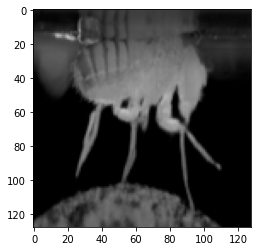

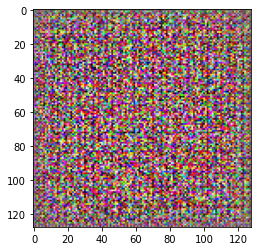

KeyboardInterrupt: ignored

In [ ]:
# Initialize the network
ae = AE(zsize=32).cuda()

# Initialize the optimizers
lr = 0.0005
ae_optimizer = optim.Adam(ae.parameters(), lr=lr, betas=(0.5, 0.999), weight_decay=1e-5)
train_epoch = 40

# For storing results
rec_loss_AB = []

for epoch in range(train_epoch):
    ae.train() # Training mode

    if (epoch + 1) % 8 == 0: # Adaptive learning rate
        ae_optimizer.param_groups[0]['lr'] /= 4
        print("learning rate change!")

    for i, data in enumerate(dataloader):
        ae.zero_grad()
        
        img_A = data['A'].cuda()
        img_B = data['B'].cuda()
        img_AB = torch.cat((img_A, img_B))

        # The embeddings
        rec_AB, z_AB = ae(img_AB)

        # The loss function --------------------------------------------------------------------------------
        loss_re_AB = loss_function(rec_AB, img_AB)

        # Backward -----------------------------------------------------------------------------------------
        (loss_re_AB).backward()
        ae_optimizer.step()

        # Store values -------------------------------------------------------------------------------------
        rec_loss_AB += [loss_re_AB.item()]

        # --------------------------------------------------------------------------------------------------
        # Print statistics
        if i % 10 == 0:
            print('epoch', epoch, 'step', i,
                  'loss_re_AB', loss_re_AB.item())

        if i % 50 == 0: # Visualize output now and then
            visualize(img_AB[0].cpu())
            visualize(rec_AB[0].detach().cpu())

## Results of the VAE training

In [ ]:
def smooth(list):
  return signal.savgol_filter(list, 101, 3)

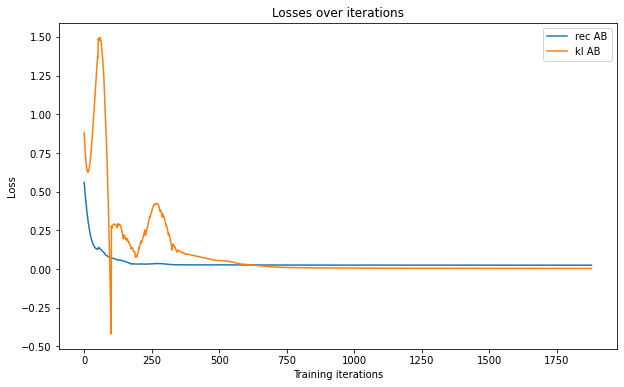

In [ ]:
plt.figure(figsize=(10,6))
plt.title('Losses over iterations')
plt.xlabel('Training iterations')
plt.ylabel('Loss')
plt.plot(smooth(rec_loss_AB))
plt.plot(smooth(kl_loss_AB))
plt.legend(['rec AB', 'kl AB'])
plt.show()

## Save/Load AE model

In [13]:
# torch.save(ae.state_dict(), '/content/drive/MyDrive/ae_AB_64')

In [14]:
# Load model
ae = AE(zsize=32).cuda()
ae.load_state_dict(torch.load('/content/drive/MyDrive/ae_AB_32'))
ae.eval()

AE(
  (conv1): Conv2d(3, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (conv1_bn): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (conv2_bn): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (conv3_bn): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv4): Conv2d(512, 1024, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (conv4_bn): BatchNorm2d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv5): Conv2d(1024, 2048, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (conv5_bn): BatchNorm2d(2048, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc1): Linear(in_features=32768, out_features=32, bias=True)
  (d1): Linear(in_features=32, out_features=32768, bias=True

## VAE latent space analyzation

Training of the VAE takes a while. This way you can load a saved model.

We are about to visualize the latent representation of the entire dataset. Since the GPU space is limited, the dataset is loaded and fed to the network in batches.

In [15]:
batch_size = 32
dataloader_all = DataLoader(dataset, batch_size, shuffle=True)

recs_AB = ()
zs_AB = ()

for i, data in enumerate(dataloader_all):
  data_AB = torch.cat((data['A'], data['B']))
  rec_AB, z_AB = ae(data_AB.cuda())
  recs_AB += (rec_AB.detach().cpu(), )
  zs_AB += (z_AB.detach().cpu(), )

recs_AB = torch.cat(recs_AB)
zs_AB = torch.cat(zs_AB)

/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:1628: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


In [16]:
def visualize_grid(img):
  plt.figure(figsize=(15,15))
  plt.imshow((img.permute(1,2,0) + 1) / 2)
  plt.axis('off')
  plt.show()

First, lets take a look at the produced reconstructions. The AE seems to translate encode the poses well, even with a small latent space of size 32.

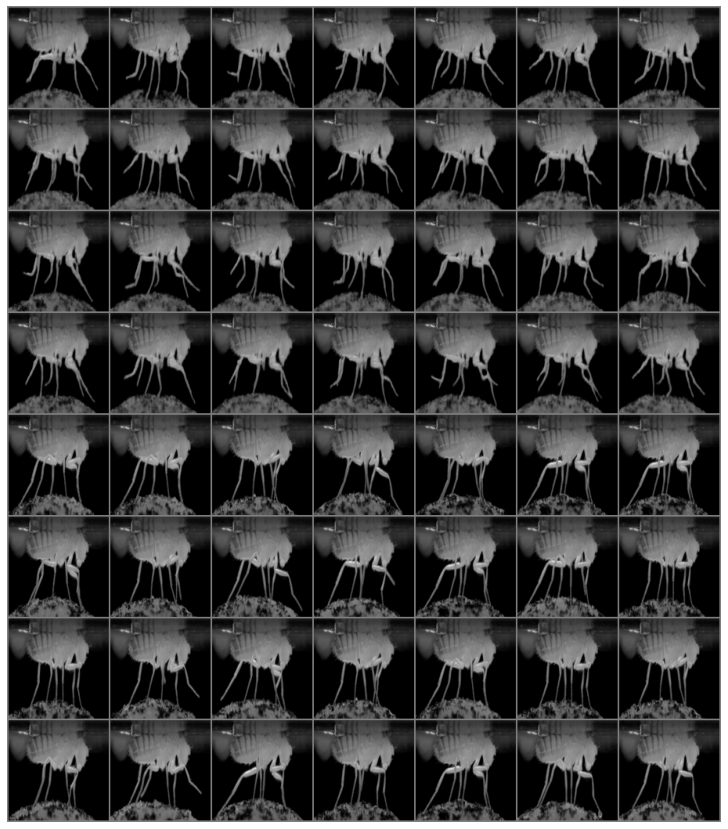

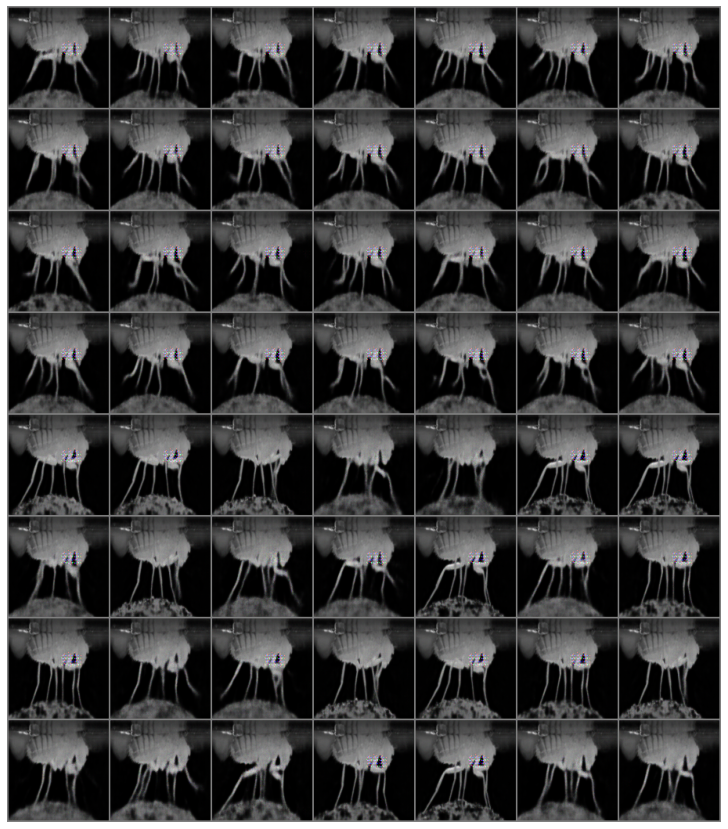

In [17]:
visualize_grid(make_grid(data_AB, nrow=7))
visualize_grid(make_grid(rec_AB.detach().cpu(), nrow=7))

In [18]:
# Perform t-SNE embedding
embedded_z = TSNE(n_components=2).fit_transform(zs_AB.detach().cpu())

In [19]:
# Get the right labels
idx = torch.zeros(3000, dtype=torch.uint8)
for i in range(93):
  if i % 2 == 0:
    idx[32*i:32*(i+1)] = 1
  
idx_A = idx==1
idx_B = idx==0

Even though the reconstructed images look not that different from one another, we can see a difference in the latent space representation between real and fake images. This means that distribution net should be able to learn the difference in distribtion of the domains.

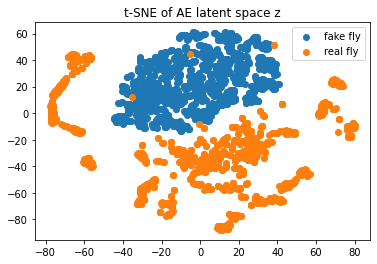

In [20]:
plt.title('t-SNE of AE latent space z')
plt.scatter(embedded_z[idx_A, 0], embedded_z[idx_A, 1])
plt.scatter(embedded_z[idx_B, 0], embedded_z[idx_B, 1])
plt.legend(['fake fly', 'real fly'])
plt.show()


In [21]:
pca = PCA(n_components=2)
pca_z = pca.fit_transform(zs_AB)

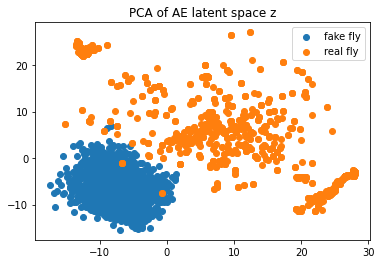

In [22]:
plt.title('PCA of AE latent space z')
plt.scatter(pca_z[idx_A, 0], pca_z[idx_A, 1])
plt.scatter(pca_z[idx_B, 0], pca_z[idx_B, 1])
plt.legend(['fake fly', 'real fly'])
plt.show()

## Annotation analyzation

In [23]:
dataset = FlyDataset(annotations=True)

anno_A = torch.Tensor(list(dataset.anno_A.values()))[:, :15].view(-1,30)
anno_B = torch.Tensor(list(dataset.anno_B.values())).view(-1,30)

In [24]:
def draw_skeleton(img, keypoints, width = 1 , r = 1):
    color = ['#A64AC9','#FCCD04','#FFB48F','F5E6CC','17E9E0','86C232' ]
    im = copy.deepcopy(img)
    d = ImageDraw.Draw(im)
    num_legs = int(len(keypoints)/5)
    for i in range(num_legs):
        x = keypoints[np.arange(0+i*5,(i+1)*5,1).tolist(),1]
        y = keypoints[np.arange(0+i*5,(i+1)*5,1).tolist(),0]
        d.line(list(zip(y,x)), fill = hex_to_rgb(color[i]),width= width)
        for j in range(5):
            d.ellipse((y[j]-r, x[j]-r, y[j]+r, x[j]+r), fill = 'red', outline ='red')
    return im

In [25]:
batch_size = 1
dataloader = DataLoader(dataset, batch_size, shuffle=True)

for dataexample in dataloader:
  img_A = dataexample['A']
  img_B = dataexample['B']

  anno_A = dataexample['A_anno'][:, :15]
  anno_B = dataexample['B_anno']

  break

fake fly


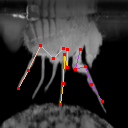

In [26]:
print('fake fly')
draw_skeleton(transforms.ToPILImage()((img_A[0] + 1) / 2).convert("RGB"), anno_A[0]*128)

real fly


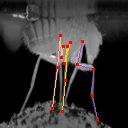

In [27]:
print('real fly')
draw_skeleton(transforms.ToPILImage()((img_B[0] + 1) / 2).convert("RGB"), anno_B[0]*128)

In [33]:
embedded_anno = TSNE(n_components=2).fit_transform(torch.cat((anno_A.view(-1, 30), anno_B.view(-1, 30))).permute(1,0))

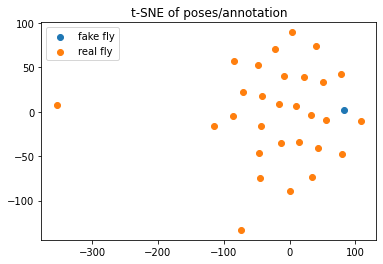

In [34]:
plt.title('t-SNE of poses/annotation')
plt.scatter(embedded_anno[:len(anno_A), 0], embedded_anno[:len(anno_A), 1])
plt.scatter(embedded_anno[len(anno_A):, 0], embedded_anno[len(anno_A):, 1])
plt.legend(['fake fly', 'real fly'])
plt.show()


In [ ]:
pca = PCA(n_components=2)
pca_anno = pca.fit_transform((torch.cat((anno_A, anno_B)).permute(1,0) - torch.cat((anno_A, anno_B)).mean(1)).permute(1,0))

In [ ]:
plt.title('PCA of poses/annotation')
plt.scatter(pca_anno[:len(anno_A), 0], pca_anno[:len(anno_A), 1])
plt.scatter(pca_anno[len(anno_A):, 0], pca_anno[len(anno_A):, 1])
plt.legend(['fake fly', 'real fly'])
plt.show()

Helge: It seems that the first (x-axis) separates them. Could you visualize that component? Do you subtract the mean before doing PCA? Then you could visualize each component as pose = mean + alpha * component_i

help?????

In [ ]:
pca = PCA(n_components=1)
pca_anno_1 = pca.fit_transform((torch.cat((anno_A, anno_B)).permute(1,0) - torch.cat((anno_A, anno_B)).mean(1)).permute(1,0)) # Subtracting the mean before doing PCA

In [ ]:
plt.title('PCA of poses/annotation')
plt.scatter(pca_anno_1[:len(anno_A), 0], torch.zeros(len(anno_A)), pca_anno_1[:len(anno_A), 0])
plt.scatter(pca_anno_1[len(anno_A):, 0], torch.zeros(len(anno_B)), pca_anno_1[len(anno_A):, 0])
plt.legend(['fake fly', 'real fly'])
plt.show()

In [ ]:
def n_centered_moment(x, w, n):
  if n > 1:
    c = n_centered_moment(x, w, 1)
  else:
    c = 0
  return (((x - c)**n)*w).sum(0)

In [ ]:
mean_anno_A = n_centered_moment(anno_A, 1/len(anno_A), 1)
mean_anno_B = n_centered_moment(anno_A, 1/len(anno_B), 1)
var_anno_A = n_centered_moment(anno_A, 1/len(anno_A), 2)
var_anno_B = n_centered_moment(anno_A, 1/len(anno_B), 2)

In [ ]:
mse = nn.MSELoss()

In [ ]:
mse(mean_anno_A, mean_anno_B), mse(var_anno_A, var_anno_B)

## Distribution network

In [35]:
class DistributionNet(nn.Module):
    '''A simple network that predicts the importances of the samples'''

    def __init__(self):
        super(DistributionNet, self).__init__()
        self.softmax = nn.Softmax(dim=0)

        self.conv1 = nn.Conv2d(3, 10, kernel_size=7)
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5)
        self.conv3 = nn.Conv2d(20, 40, kernel_size=5)
        self.fc1 = nn.Linear(40*12*12, 40)
        self.fc2 = nn.Linear(40, 1)
        
    def forward(self, x):
        h1 = torch.sigmoid(F.max_pool2d(self.conv1(x), 2))
        h2 = torch.sigmoid(F.max_pool2d(self.conv2(h1), 2))
        h3 = torch.sigmoid(F.max_pool2d(self.conv3(h2), 2))
        h4 = h3.view(-1, 40*12*12)
        h5 = torch.sigmoid(self.fc1(h4))
        out = self.fc2(h5)
        return self.softmax(out), out

## Training of distribution net

The goal of this network is to predict the relative frequency of samples.

In [ ]:
dataset = FlyDataset(annotations=True)

batch_size = 32
dataloader = DataLoader(dataset, batch_size, shuffle=True)

In [ ]:
# Initialize the networks
distribution_network = DistributionNet().cuda()
# Initialize the optimizers
lr = 0.001
optimizer_d = optim.Adam(distribution_network.parameters(), lr=lr)

criterion_d = nn.MSELoss()
mse = nn.MSELoss()

# For storing results
losses_d = []

means_A = []
means_B = []

vars_A = []
vars_B = []

moments_A = []
moments_B = []

anno_means_A = []
anno_means_B = []
anno_vars_A = []
anno_vars_B = []
anno_mse_means = []
anno_mse_vars = []

n = 1 # n-centered moment
ae.eval()

for epoch in range(40):
    for i, data in enumerate(dataloader):
        
        img_A = data['A'].cuda()
        img_B = data['B'].cuda()

        anno_A = data['A_anno'][:, :15].cuda()
        anno_B = data['B_anno'].cuda()

        # The embeddings
        rec_A, z_A = ae(img_A)
        rec_B, z_B = ae(img_B)

        # The weighting process
        w_A = distribution_network(img_A)[0]
        w_B = 1/len(img_B)

        # The loss function --------------------------------------------------------------------------------
        n_centered_moment_A = n_centered_moment(z_A.detach(), w_A, n)
        n_centered_moment_B = n_centered_moment(z_B.detach(), w_B, n)
        loss_d = criterion_d(n_centered_moment_A, n_centered_moment_B)

        # mean_anno_A = n_centered_moment(anno_A.view(-1, 30), w_A, 1)
        # mean_anno_B = n_centered_moment(anno_B.view(-1, 30), w_B, 1)
        # var_anno_A = n_centered_moment(anno_A.view(-1, 30), w_A, 2)
        # var_anno_B = n_centered_moment(anno_B.view(-1, 30), w_B, 2)
        # mse_mean_anno = mse(mean_anno_A, mean_anno_B)
        # mse_var_anno = mse(var_anno_A, var_anno_B)

        # ---------------------------------------------------------------------------------------------------

        # Backward
        optimizer_d.zero_grad()
        loss_d.backward()
        optimizer_d.step() 

        # Store values --------------------------------------------------------------------------------------
        moments_A += [n_centered_moment_A.cpu().detach().numpy()]
        moments_B += [n_centered_moment_B.cpu().detach().numpy()]

        means_A += [n_centered_moment(z_A, w_A, 1).detach().cpu().numpy()]
        means_B += [n_centered_moment(z_B, w_B, 1).detach().cpu().numpy()]

        vars_A += [n_centered_moment(z_A, w_A, 2).detach().cpu().numpy()]
        vars_B += [n_centered_moment(z_B, w_B, 2).detach().cpu().numpy()]

        anno_means_A += [mean_anno_A.detach().cpu().numpy()]
        anno_means_B += [mean_anno_B.detach().cpu().numpy()]
        anno_vars_A += [var_anno_A.detach().cpu().numpy()]
        anno_vars_B += [var_anno_B.detach().cpu().numpy()]

        anno_mse_means += [mse_mean_anno.item()]
        anno_mse_vars += [mse_var_anno.item()]

        losses_d += [loss_d.item()]

        # ---------------------------------------------------------------------------------------------------

        # Print statistics
        if i % 10 == 0:
            print('epoch', epoch, 'step', i, 'loss_d: ', loss_d.item())
            
        if i % 10000 == 0 and i != 0:
            break

/usr/local/lib/python3.6/dist-packages/torch/nn/functional.py:1628: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


epoch 0 step 0 loss_d:  16.290863037109375
epoch 0 step 10 loss_d:  18.688873291015625
epoch 0 step 20 loss_d:  13.53515625
epoch 0 step 30 loss_d:  16.37873077392578
epoch 0 step 40 loss_d:  13.453733444213867
epoch 1 step 0 loss_d:  12.535792350769043
epoch 1 step 10 loss_d:  14.08259391784668
epoch 1 step 20 loss_d:  14.795511245727539
epoch 1 step 30 loss_d:  13.935364723205566
epoch 1 step 40 loss_d:  12.646188735961914
epoch 2 step 0 loss_d:  14.238706588745117
epoch 2 step 10 loss_d:  15.118614196777344
epoch 2 step 20 loss_d:  14.694875717163086
epoch 2 step 30 loss_d:  12.50393009185791
epoch 2 step 40 loss_d:  12.07559585571289
epoch 3 step 0 loss_d:  12.503068923950195
epoch 3 step 10 loss_d:  11.602684020996094
epoch 3 step 20 loss_d:  15.960695266723633
epoch 3 step 30 loss_d:  11.150925636291504
epoch 3 step 40 loss_d:  11.986066818237305
epoch 4 step 0 loss_d:  14.419646263122559
epoch 4 step 10 loss_d:  16.383220672607422
epoch 4 step 20 loss_d:  13.861406326293945
epoc

In [ ]:
moments_A = torch.Tensor(moments_A)
moments_B = torch.Tensor(moments_B)
means_A = torch.Tensor(means_A)
means_B = torch.Tensor(means_B)
vars_A = torch.Tensor(vars_A)
vars_B = torch.Tensor(vars_B)

anno_means_A = torch.Tensor(anno_means_A)
anno_means_B = torch.Tensor(anno_means_B)
anno_vars_A = torch.Tensor(anno_vars_A)
anno_vars_B = torch.Tensor(anno_vars_B)
anno_mse_means = torch.Tensor(anno_mse_means)
anno_mse_vars = torch.Tensor(anno_mse_vars)

## Results of distribution net

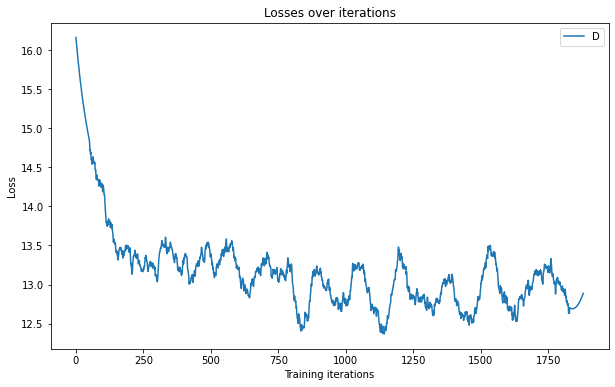

In [ ]:
plt.figure(figsize=(10,6))
plt.title('Losses over iterations')
plt.xlabel('Training iterations')
plt.ylabel('Loss')
smoothed_losses_d = signal.savgol_filter(losses_d,101,3)
plt.plot(smoothed_losses_d)
plt.legend(['D'])
plt.show()

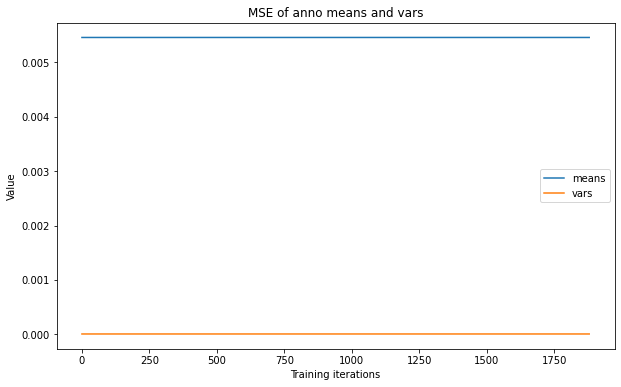

In [ ]:
plt.figure(figsize=(10,6))
plt.title('MSE of anno means and vars')
plt.xlabel('Training iterations')
plt.ylabel('Value')
smoothed_anno_mse_means = signal.savgol_filter(anno_mse_means,101,3)
smoothed_anno_mse_vars = signal.savgol_filter(anno_mse_vars,101,3)
plt.plot(smoothed_anno_mse_means)
plt.plot(smoothed_anno_mse_vars)
plt.legend(['means', 'vars'])
plt.show()

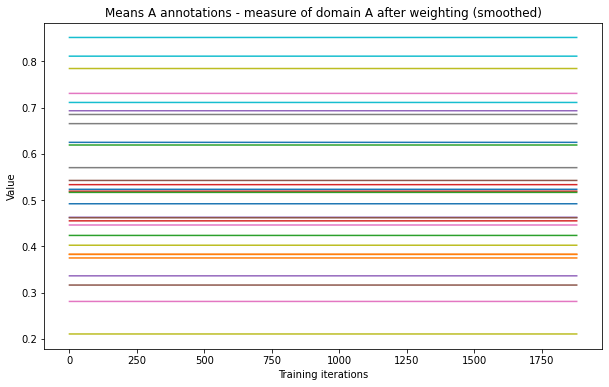

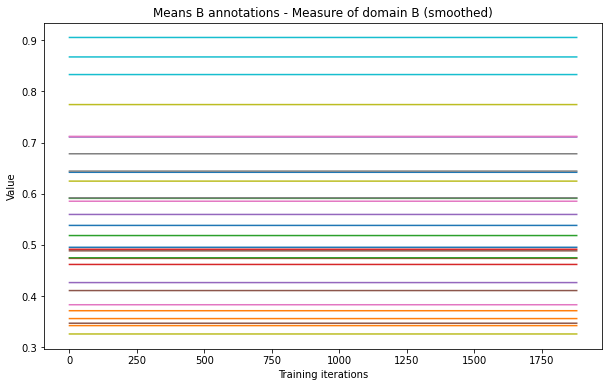

In [ ]:
plt.figure(figsize=(10,6))
plt.title('Means A annotations - measure of domain A after weighting (smoothed)')
plt.xlabel('Training iterations')
plt.ylabel('Value')
# plt.ylim(ymax = moments_A.max(), ymin = moments_A.min())
smoothed_Lmin = signal.savgol_filter(anno_means_A,101,3,axis=0)
plt.plot(smoothed_Lmin)
# plt.legend(np.arange(len(moments_A[0])))
plt.show()

plt.figure(figsize=(10,6))
plt.title('Means B annotations - Measure of domain B (smoothed)')
plt.xlabel('Training iterations')
plt.ylabel('Value')
# plt.ylim(ymax = moments_A.max(), ymin = moments_A.min())
smoothed_Lplus = signal.savgol_filter(anno_means_B,101,3,axis=0)
plt.plot(smoothed_Lplus)
# plt.legend(np.arange(len(moments_A[0])))
plt.show()

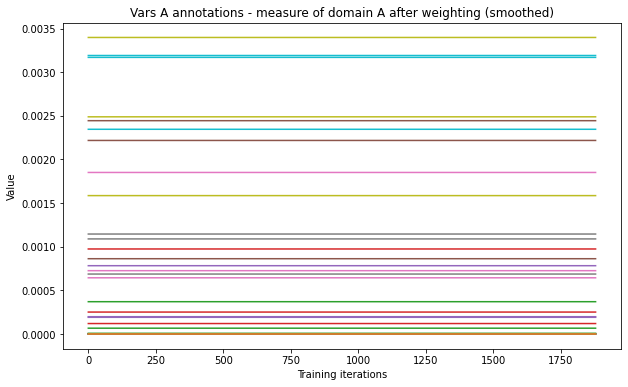

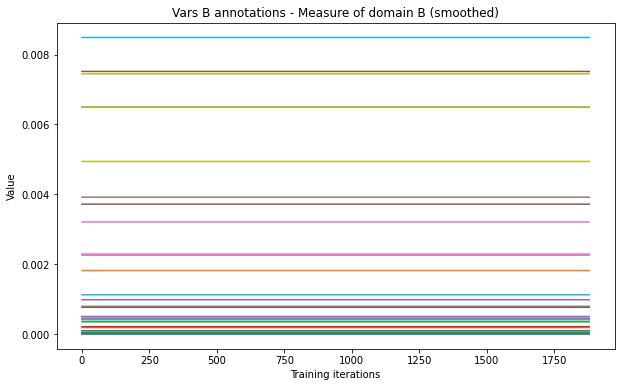

In [ ]:
plt.figure(figsize=(10,6))
plt.title('Vars A annotations - measure of domain A after weighting (smoothed)')
plt.xlabel('Training iterations')
plt.ylabel('Value')
# plt.ylim(ymax = moments_A.max(), ymin = moments_A.min())
smoothed_Lmin = signal.savgol_filter(anno_vars_A,101,3,axis=0)
plt.plot(smoothed_Lmin)
# plt.legend(np.arange(len(moments_A[0])))
plt.show()

plt.figure(figsize=(10,6))
plt.title('Vars B annotations - Measure of domain B (smoothed)')
plt.xlabel('Training iterations')
plt.ylabel('Value')
# plt.ylim(ymax = moments_A.max(), ymin = moments_A.min())
smoothed_Lplus = signal.savgol_filter(anno_vars_B,101,3,axis=0)
plt.plot(smoothed_Lplus)
# plt.legend(np.arange(len(moments_A[0])))
plt.show()

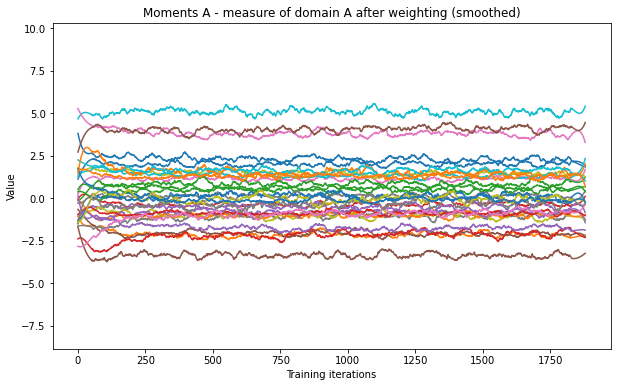

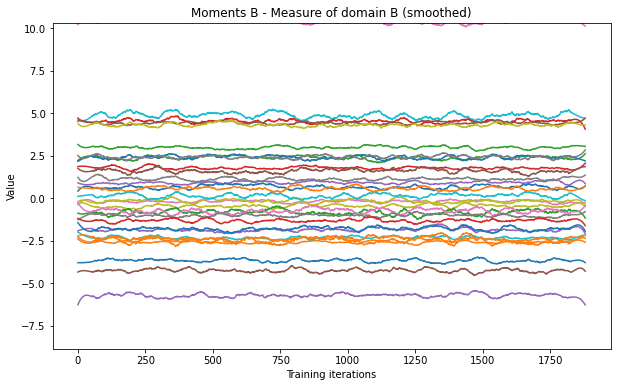

In [ ]:
plt.figure(figsize=(10,6))
plt.title('Moments A - measure of domain A after weighting (smoothed)')
plt.xlabel('Training iterations')
plt.ylabel('Value')
plt.ylim(ymax = moments_A.max(), ymin = moments_A.min())
smoothed_Lmin = signal.savgol_filter(moments_A,101,3,axis=0)
plt.plot(smoothed_Lmin)
# plt.legend(np.arange(len(moments_A[0])))
plt.show()

plt.figure(figsize=(10,6))
plt.title('Moments B - Measure of domain B (smoothed)')
plt.xlabel('Training iterations')
plt.ylabel('Value')
plt.ylim(ymax = moments_A.max(), ymin = moments_A.min())
smoothed_Lplus = signal.savgol_filter(moments_B,101,3,axis=0)
plt.plot(smoothed_Lplus)
# plt.legend(np.arange(len(moments_A[0])))
plt.show()

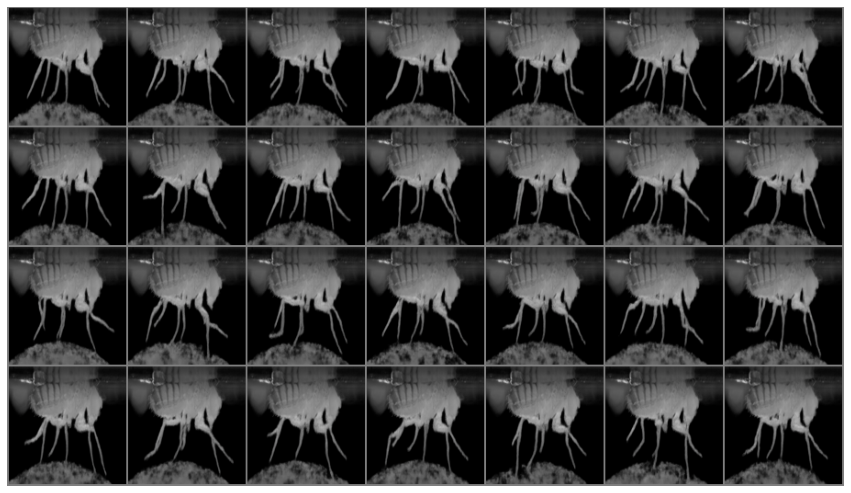

0 0.005444394424557686
1 0.12663474678993225
2 0.5580695867538452
3 3.0145349502563477
4 0.11077731847763062
5 0.5639063715934753
6 2.324777841567993
7 0.010093554854393005
8 0.21271033585071564
9 0.3239101469516754
10 3.022563934326172
11 0.2493177056312561
12 0.0037849354557693005
13 0.015289705246686935
14 2.837846517562866
15 0.00440231803804636
16 0.32654282450675964
17 0.008322431705892086
18 0.07230298966169357
19 2.1119658946990967
20 4.810234546661377
21 0.04776011034846306
22 3.539165496826172
23 1.5257420539855957
24 0.04428606852889061
25 0.4819241166114807
26 0.006593899801373482
27 1.6410949230194092


In [ ]:
# These are generated images
weights = distribution_network(img_A)[0]
weights *= len(weights)

visualize_grid(make_grid(img_A.cpu(), nrow=7))

for i, weight in enumerate(weights):
  print(i, weight.item())

## Save/load distribution weights

In [36]:
# torch.save(distribution_network.state_dict(), '/content/drive/MyDrive/distributionnet')

In [37]:
# Load model
distribution_network = DistributionNet().cuda()
distribution_network.load_state_dict(torch.load('/content/drive/MyDrive/distributionnet'))
distribution_network.eval()

DistributionNet(
  (softmax): Softmax(dim=0)
  (conv1): Conv2d(3, 10, kernel_size=(7, 7), stride=(1, 1))
  (conv2): Conv2d(10, 20, kernel_size=(5, 5), stride=(1, 1))
  (conv3): Conv2d(20, 40, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=5760, out_features=40, bias=True)
  (fc2): Linear(in_features=40, out_features=1, bias=True)
)

## More results

In [38]:
dataset = FlyDataset(annotations=True)

batch_size = 512
dataloader = DataLoader(dataset, batch_size, shuffle=True)

for dataexample in dataloader:
  img_A = dataexample['A'].cuda()
  img_B = dataexample['B'].cuda()

  anno_A = dataexample['A_anno'][:, :15].view(-1,30)
  anno_B = dataexample['B_anno'].view(-1,30)

  break

weights = distribution_network(img_A)[0].detach().cpu()

In [98]:
pca = PCA(n_components=4)
# pca_anno = pca.fit_transform((torch.cat((anno_A, anno_B))))
# pca_anno = pca.fit_transform(anno_A)
pca_anno = pca.fit_transform(anno_B)

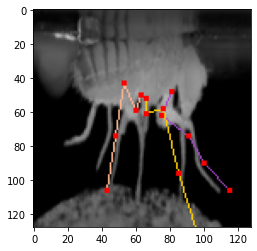

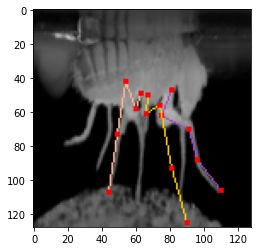

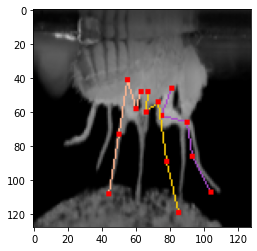

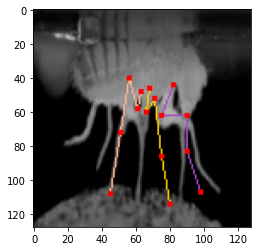

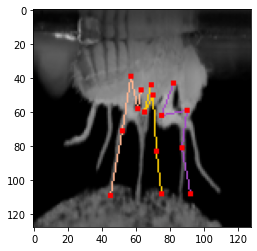

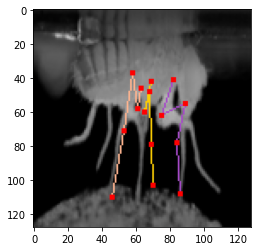

In [99]:
for weight in np.arange(-0.3, 0.3, 0.1):
  pose_components = weight*pca.components_[3] + pca.mean_
  plt.imshow(draw_skeleton(transforms.ToPILImage()((img_A[0] + 1) / 2).convert("RGB"), pose_components.reshape(15,2)*128))
  plt.show()

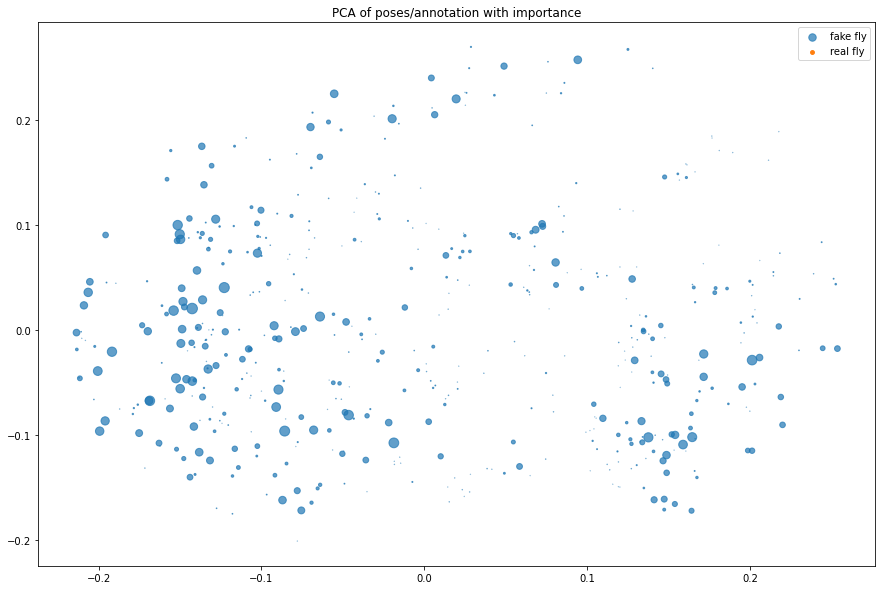

In [95]:
scale = 15
plt.figure(figsize=(15,10))
plt.title('PCA of poses/annotation with importance')
plt.scatter(pca_anno[:len(anno_A), 0], pca_anno[:len(anno_A), 1], scale*(weights*len(weights)), alpha=0.7)
plt.scatter(pca_anno[len(anno_A):, 0], pca_anno[len(anno_A):, 1], scale)
plt.legend(['fake fly', 'real fly'])
plt.show()

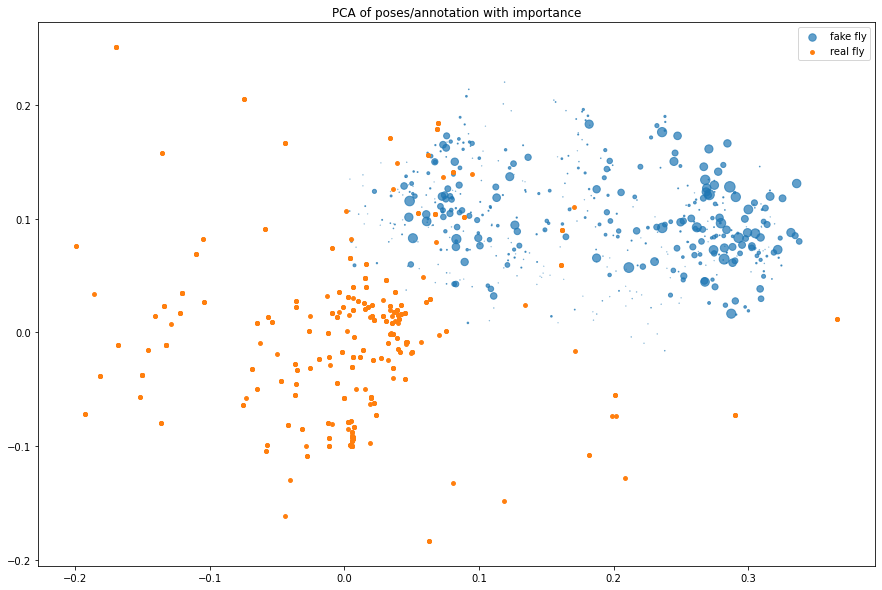

In [103]:
pca_anno_AB = pca.transform(torch.cat((anno_A, anno_B)))

scale = 15
plt.figure(figsize=(15,10))
plt.title('PCA of poses/annotation with importance')
plt.scatter(pca_anno_AB[:len(anno_A), 2], pca_anno_AB[:len(anno_A), 3], scale*(weights*len(weights)), alpha=0.7)
plt.scatter(pca_anno_AB[len(anno_A):, 2], pca_anno_AB[len(anno_A):, 3], scale)
plt.legend(['fake fly', 'real fly'])
plt.show()

In [ ]:
# TODO: sort on component and visualize images
# Train AE on fake data only
# interpolation on AE latent space: look at similarity between PCA and AE latent space interpolations
# interpolation of AE reconstructed images 
# VAE with lower weight on prior
# Future work: generate realistic poses
# Filter out part of fake images